Install Jupyter dash

In [1]:
#pip install jupyter-dash

Gather needed Imports

In [15]:
import plotly.express as px
import plotly.graph_objs as go
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd
from datetime import date
import numpy as np
from urllib.request import urlopen
import json
from IPython.display import Image

Retrieving data from csv, readying it for use (inding only US data, getting new deaths/cases and total deaths/ cases, etc.)

Gets data from respective csv files, removes any "Statewide Unallocated" data from county name from all files.

In [3]:
cases = pd.read_csv("../../../data/stage_1/covid_confirmed_usafacts.csv")
deaths = pd.read_csv("../../../data/stage_1/covid_deaths_usafacts.csv")
pop = pd.read_csv("../../../data/stage_1/covid_county_population_usafacts.csv")

cases = cases[cases['County Name'] != 'Statewide Unallocated']
deaths = deaths[deaths['County Name'] != 'Statewide Unallocated']

pop = pop[pop['County Name'] != 'Statewide Unallocated']
pop = pop.drop(columns = ['County Name'])

Merges data from all files and makes the dates into a column that will later be used to group the covid cases and deaths.

In [4]:
deathsandpop = pd.merge(deaths, pop, on = ['countyFIPS', 'State'])
deathsandpop2 = pd.melt(deathsandpop, id_vars=['countyFIPS','State','County Name','StateFIPS','population'],var_name='Date', value_name='Deaths')
cases_long = pd.melt(cases, id_vars=['countyFIPS','State','County Name','StateFIPS'], var_name='Date', value_name='Cases')
alldata = pd.merge(deathsandpop2,cases_long, on=['countyFIPS','State','County Name','StateFIPS', 'Date'])

Changes date column to datetime type.

In [5]:
alldata['Date']=alldata['Date'].astype('datetime64[ns]')
alldata['countyFIPS']=alldata['countyFIPS'].astype(str)

Group Data by county to be used for the map.

In [6]:
countydata = alldata.groupby(['countyFIPS','population','State']).sum().reset_index(drop=False)
countymeanpop = countydata['population'].mean()

Normalized Case/Death info and insert columns into dataframe

In [7]:
Norm_Cases = (countydata['Cases'] / countymeanpop)* 10000
Norm_Deaths = (countydata['Deaths'] / countymeanpop)* 10000

In [8]:
countydata.insert(6, 'Norm_Cases',Norm_Cases)
countydata.insert(6, 'Norm_Deaths',Norm_Deaths)

Convert CountyFIP codes to be 5 digits

In [9]:
countydata['countyFIPS']=countydata['countyFIPS'].str.rjust(5,'0')

### Trendlines for Each State's Cases/Deaths

Building app

In [10]:
# Build App
app = JupyterDash(__name__)

#DropDown list
app.layout = html.Div(children=[
    
    html.Div([
    html.H1(children='US Rolling Average of New Covid Cases and Deaths By State'),
    
    dcc.Dropdown(id='dropdown', options=[
        {'label': i, 'value': i} for i in alldata.State.unique()
    ], value='AL',multi=False),
    
    dcc.RadioItems(
    id='radio-items',    
    options=[
        {'label': 'Rolling Avg: New Deaths', 'value': 'New_Deaths'},
        {'label': 'Rolling Avg: New Cases', 'value': 'New_Cases'}
    ],
    value='New_Deaths',
    labelStyle={'display': 'inline-block'}
    ),
    
    dcc.Graph(id='graph1'),
        
    ])
])

@app.callback(
    Output('graph1', 'figure'),
    [Input('dropdown', 'value'), Input('radio-items','value')]
)

def build_graph(state, data):
    
    #Separate state chosen by user and group by date
    figdf = alldata[alldata['State'] == state]
    figdf= figdf.groupby('Date').sum().reset_index(drop=False)
    
    #Calculate new cases and deaths
    figdf['New_Cases'] = figdf.Cases.diff().fillna(0)
    figdf['New_Deaths'] = figdf.Deaths.diff().fillna(0)
    figdf['New_Cases']  = np.where(figdf['New_Cases']  < 0, 0, figdf['New_Cases'])
    figdf['New_Deaths'] = np.where(figdf['New_Deaths'] < 0, 0, figdf['New_Deaths'])
    
    figdf['data'] = figdf[data].rolling(window=7).mean().fillna(0)
    fig= px.scatter(figdf, x ='Date', y='data', color='data')
    fig.update_traces(mode='lines+markers')
    
    return fig

# Run app and display result inline in the notebook
app.run_server(mode='inline')

Screenshot to display in GitHub

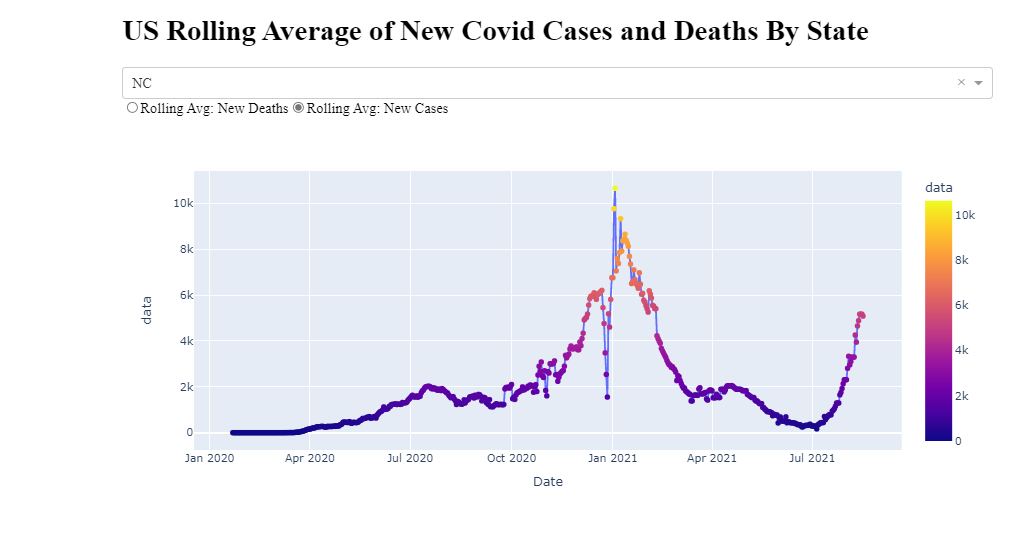

In [23]:
PATH = "../../../data/stage_4/screenshot.png"
Image(filename = PATH, width=1000, height=1100)

### Choropleth Map of United States Covid Deaths

Get JSON with geo locations of counties. Use JSON and countyFIPs to make choropleth map of Covid Deaths all over the US.

In [11]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

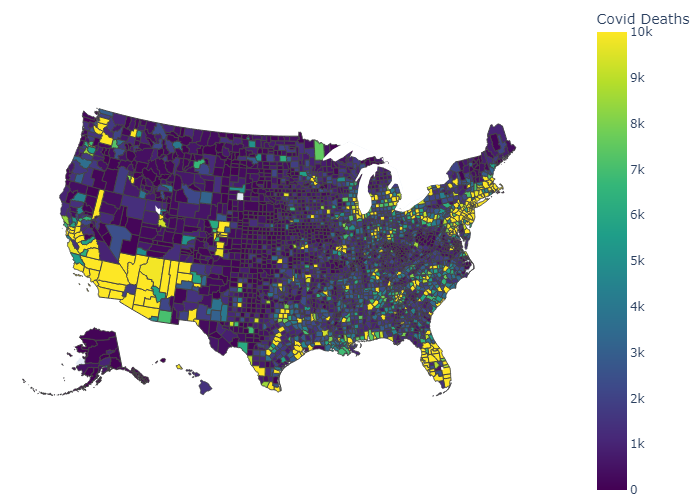

In [13]:
fig = px.choropleth(countydata, geojson=counties, locations='countyFIPS', color='Norm_Deaths',
                           color_continuous_scale="Viridis",
                           range_color=(0, 10000),
                           scope="usa",
                           labels={'Norm_Deaths':'Covid Deaths'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show("png")